# BAL pseudobulk analysis, pt. 4

In [1]:
import collections
import itertools
import functools
import json
import math
import os
import sys
import pathlib
import datetime

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy
import statsmodels.stats.multitest
import statsmodels.regression
import statsmodels.api

import decoupler

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.insert(0, "../lib/")

In [3]:
import sc_utils

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [6]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# plt.rcParams['figure.constrained_layout.use'] = False
# mpl.rcParams['mathtext.default'] = 'regular'

In [7]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [8]:
ds_processed = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [9]:
DATA_DIR = DATA / 'pseudobulk-gsva'

In [10]:
DEG_DIR = DATA / '11_pseudobulk-v3'

In [11]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

In [12]:
def get_cell_type_from_slug(slug: str, ds: sc.AnnData) -> str:
    for cell_type in ds.obs.cell_type.unique():
        cell_type_slug = cell_type.replace(" ", "_").replace("/", "_")
        if slug == cell_type_slug:
            return cell_type
    raise ValueError(f"Cannot find cluster for {slug}")

In [13]:
MODEL = 'degs-status-sex'

def load_cell_type_info(folder, data_folder):
    name = folder.name
    degs = pd.read_csv(folder / MODEL / 'degs.csv', index_col=0)
    degs_filt = pd.read_csv(folder / MODEL / 'degs-filt.csv', index_col=0)
    expr = pd.read_table(data_folder / 'data' / f'{name}.txt', index_col=0)
    gene_cells = pd.read_table(data_folder / 'data' / f'{name}-n_cells.txt', index_col=0)
    meta = pd.read_csv(folder / 'meta.csv', index_col=0)

    go_ctrl = folder / MODEL / 'go-control.csv'
    if go_ctrl.exists():
        go_ctrl = pd.read_csv(go_ctrl, index_col=0)
    else:
        go_ctrl = None

    go_ssc = folder / MODEL / 'go-ssc.csv'
    if go_ssc.exists():
        go_ssc = pd.read_csv(go_ssc, index_col=0)
    else:
        go_ssc = None

    # ensure we operate on filtered samples
    gene_cells = gene_cells.loc[:, meta["External Sample ID"]]
    gene_cells = gene_cells.loc[gene_cells.sum(axis=1) > 0, :]

    return {
        'degs': degs,
        'filtered_degs': degs_filt,
        'meta': meta,
        'gene_cells': gene_cells,
        'expr': expr,
        'go_control': go_ctrl,
        'go_ssc': go_ssc,
    }


def process_cell_type(folder, data_folder):
    info = {}

    clust = get_cell_type_from_slug(folder.name, ds_processed)
    info.update(load_cell_type_info(folder, data_folder))

    return info

In [14]:
data = {}

for folder in sorted(DEG_DIR.iterdir()):
    if not folder.is_dir():
        continue
    if not (folder / MODEL).exists():
        continue
    if folder.name == 'global':
        continue
    data[folder.name] = process_cell_type(folder, DATA_DIR / folder.name)

# 1. Linear models on DEGs

In [13]:
deg_cell_types = [
    'MoAM-3 mature', 'Proliferating macrophages', 'TRAM-1',
    'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated'
]

In [14]:
ct_slugs = [i.replace(' ', '_').replace('*', '').replace(';', '_and') for i in deg_cell_types]

In [15]:
all_degs = []
for ct, info in data.items():
    if ct not in ct_slugs:
        continue
    degs = info['filtered_degs']
    all_degs.append(degs.index[degs.sign.notna() & degs.log2FoldChange.abs().gt(0.7)].tolist())
all_degs = functools.reduce(np.union1d, all_degs)

In [16]:
all_degs.size

1023

In [17]:
metadata_df = ds_processed.obs.loc[
    ds_processed.obs.Chemistry.eq("10x 3' V3")
    & ds_processed.obs.cell_type.isin(deg_cell_types)
][
    ['External Sample ID', 'Status']
].drop_duplicates(subset=['External Sample ID'])

In [18]:
pseudobulk = np.zeros((metadata_df.shape[0], all_degs.size))
gene_idx = ds_processed.raw.var_names.isin(all_degs)
gene_names = ds_processed.raw.var_names[gene_idx]
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        ds_processed.obs.cell_type.isin(deg_cell_types)
        & ds_processed.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = ds_processed.raw.X[metadata_idx][:, gene_idx].mean(axis=0)

In [19]:
pseudobulk.shape

(14, 1023)

In [20]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=gene_names)

In [21]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [36]:
clinical_data = pd.read_csv('../00clinical-v2.csv')

In [38]:
samples = pd.read_csv("../00all-samples.csv")

In [39]:
clinical_data = clinical_data.merge(
    samples[['Sample', 'External Sample ID']],
    left_on='study_code',
    right_on='Sample',
    how='left'
)

In [40]:
sample_to_fvc = clinical_data.set_index('External Sample ID').fvc_pred

In [41]:
sample_to_fev1 = clinical_data.set_index('External Sample ID').fev1_pred

In [28]:
idx = metadata_df['External Sample ID'].isin(sample_to_fvc.index)
metadata_df.loc[idx, 'fvc_pred'] = sample_to_fvc[metadata_df['External Sample ID'][idx]].values
metadata_df.loc[idx, 'fev1_pred'] = sample_to_fev1[metadata_df['External Sample ID'][idx]].values

In [29]:
result = []
for gene in pseudobulk.columns:
    idx = metadata_df.fvc_pred.notna()
    y = pseudobulk[gene][idx]
    x = metadata_df.fvc_pred[idx]
    fvc_fit = scipy.stats.pearsonr(x, y)
    x = metadata_df.fev1_pred[idx]
    fev1_fit = scipy.stats.pearsonr(x, y)
    result.append((
        gene,
        fvc_fit.statistic,
        fvc_fit.pvalue,
        fev1_fit.statistic,
        fev1_fit.pvalue,
    ))
result = pd.DataFrame(
    result,
    columns=['gene', 'fvc_corr', 'fvc_pval', 'fev1_corr', 'fev1_pval']
)

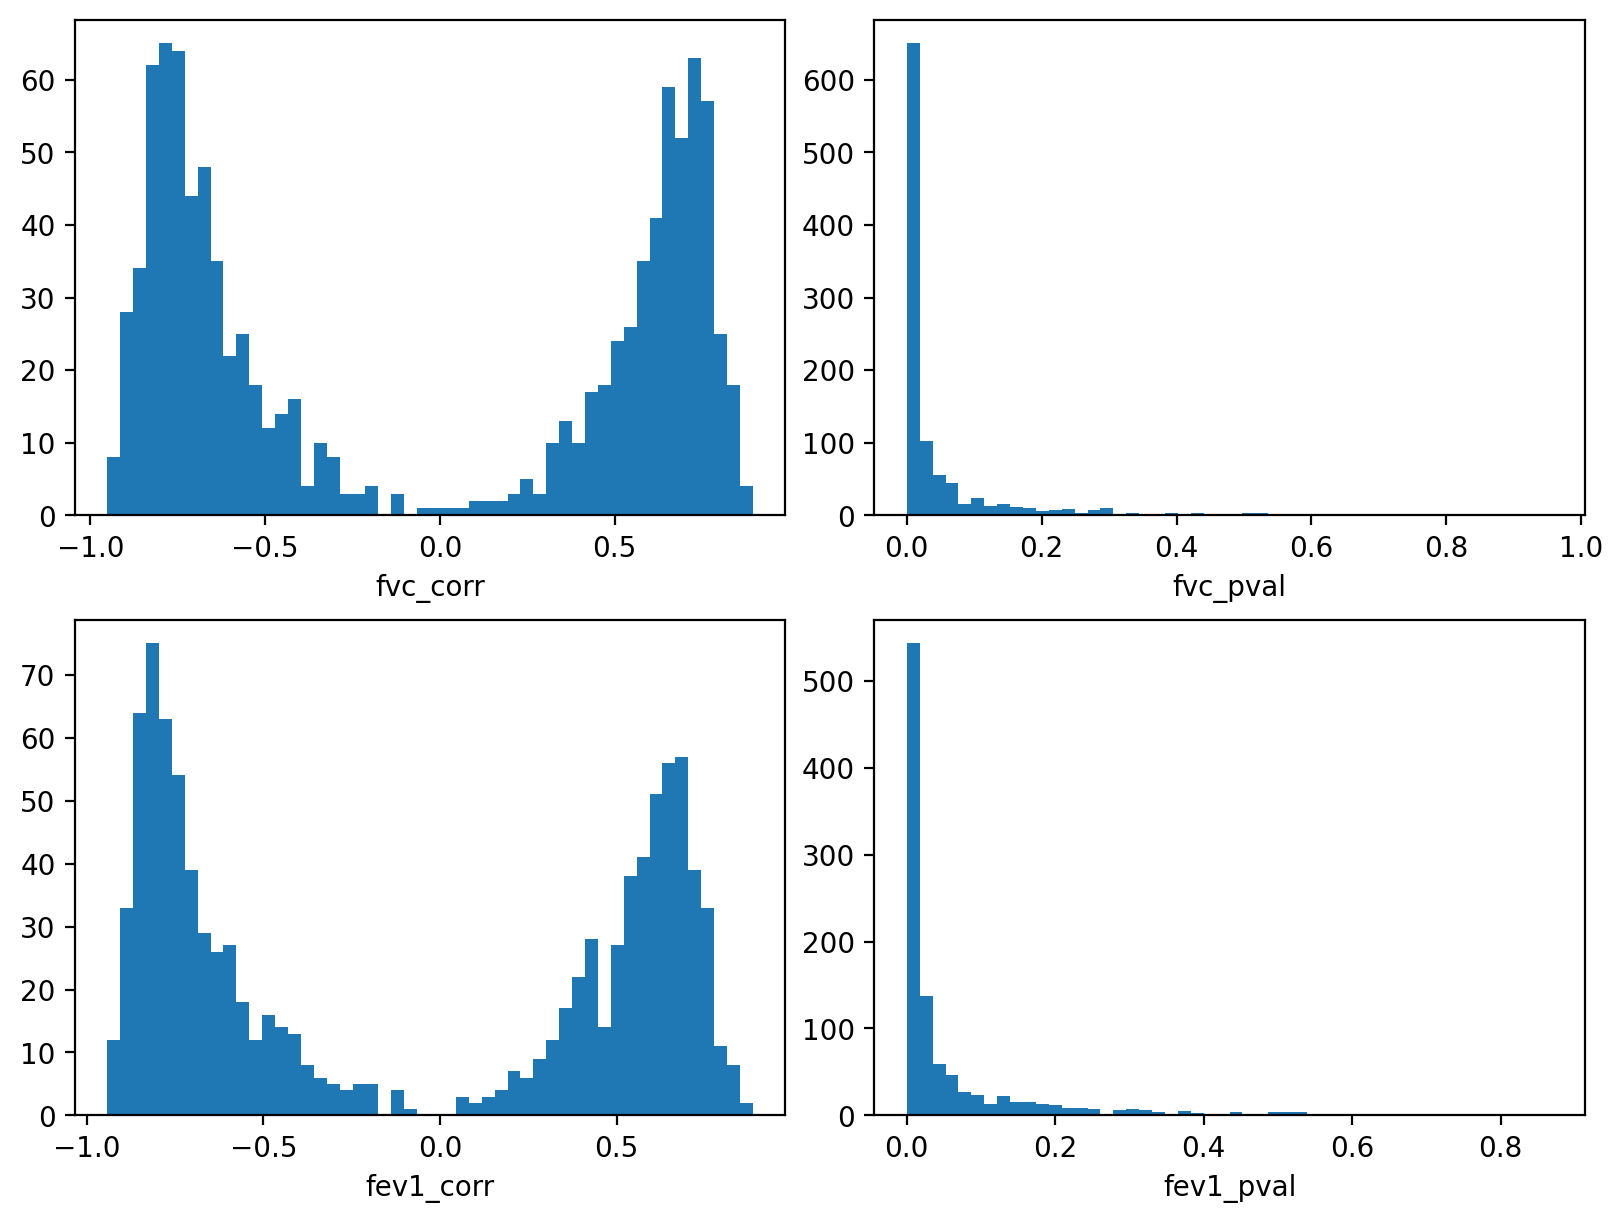

In [30]:
fig, axes = plt.subplots(figsize=(8, 6), ncols=2, nrows=2, constrained_layout=True)
for i, col in enumerate(
    ('fvc_corr', 'fvc_pval', 'fev1_corr', 'fev1_pval')
):
    ax = axes[i // 2, i % 2]
    ax.hist(result[col], bins=50)
    ax.set_xlabel(col)

In [31]:
result['fvc_padj'] = statsmodels.stats.multitest.fdrcorrection(result.fvc_pval)[1]
result['fev1_padj'] = statsmodels.stats.multitest.fdrcorrection(result.fev1_pval)[1]

In [32]:
result.sort_values('fvc_padj').head(20)

,gene,fvc_corr,fvc_pval,fev1_corr,fev1_pval,fvc_padj,fev1_padj
628,CREM,-0.951614,5.657220e-07,-0.926161,0.000006,0.000579,0.001017
470,GGH,-0.940166,1.779144e-06,-0.866838,0.000125,0.000836,0.002547
860,PMP22,-0.934576,2.876283e-06,-0.940188,0.000002,0.000836,0.000908
1016,CSTB,-0.932957,3.279599e-06,-0.915598,0.000011,0.000836,0.001299
871,CCL18,-0.930149,4.087458e-06,-0.846181,0.000266,0.000836,0.003353
689,TUBA1A,-0.922188,7.286153e-06,-0.941979,0.000002,0.001174,0.000908
30,PPIH,-0.916094,1.089927e-05,-0.895469,0.000035,0.001174,0.001887
508,CKS2,-0.913757,1.261859e-05,-0.873066,0.000098,0.001174,0.002433
740,RNASE1,-0.914059,1.238497e-05,-0.864027,0.000140,0.001174,0.002618
373,CENPW,-0.916264,1.078210e-05,-0.926912,0.000005,0.001174,0.001017


Text(0, 0.5, 'z-score$(CREM)$')

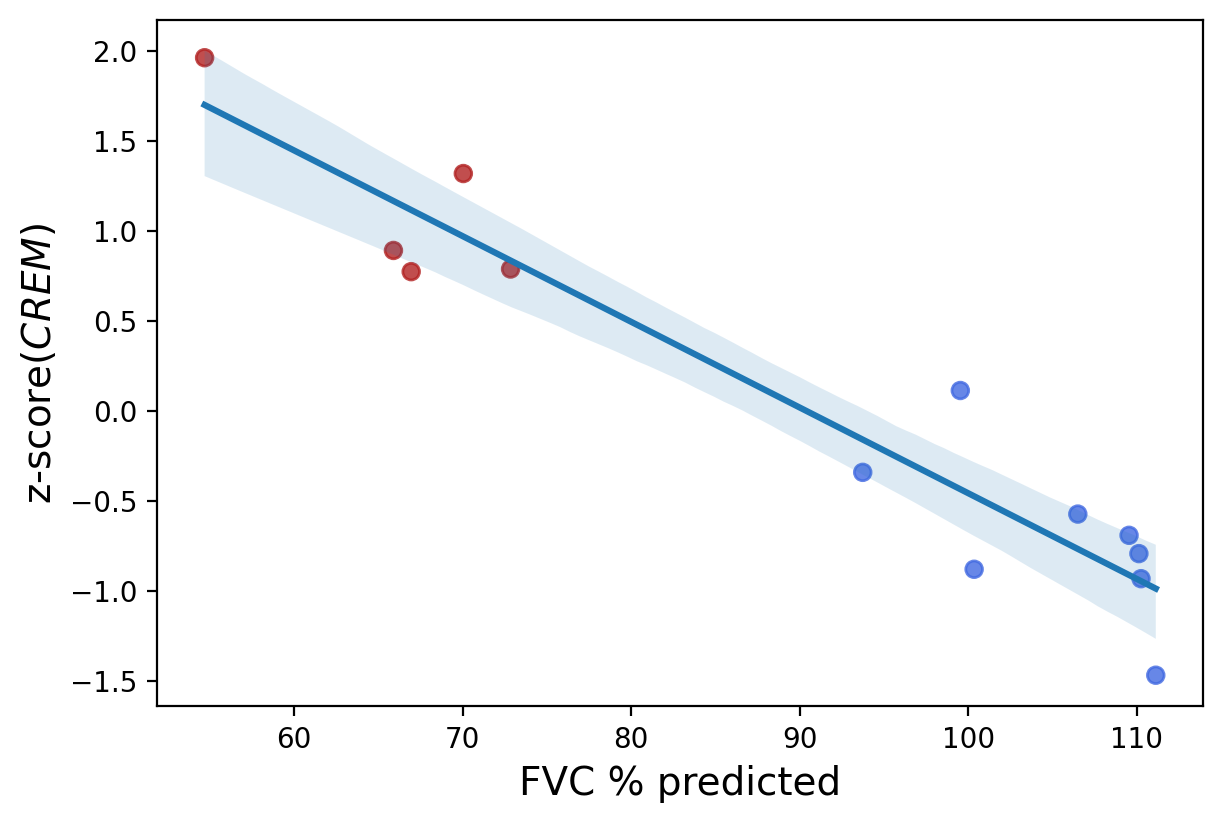

In [33]:
GENE = 'CREM'
idx = metadata_df.fvc_pred.notna()
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
sns.regplot(
    x=metadata_df.fvc_pred[idx],
    y=pseudobulk[GENE][idx],
    scatter_kws=dict(
        color=get_color_annotations(
            metadata_df[idx],
            {'Status': ['firebrick', 'royalblue']}
        ).Status.tolist()
    )
)
ax.set_xlabel('FVC % predicted', size=14)
ax.set_ylabel(f'z-score$({GENE})$', size=14)

In [34]:
result.sort_values('fvc_padj').to_csv('12a_degs_tram_corr.csv')

# 2. Linear models on genes

In [35]:
metadata_df = ds_processed.obs.loc[
    ds_processed.obs.cell_type.isin(deg_cell_types)
][
    ['External Sample ID', 'Status']
].drop_duplicates(subset=['External Sample ID'])

In [36]:
pseudobulk = np.zeros((metadata_df.shape[0], ds_processed.raw.var_names.size))
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        ds_processed.obs.cell_type.isin(deg_cell_types)
        & ds_processed.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = ds_processed.raw.X[metadata_idx].mean(axis=0)

In [37]:
pseudobulk.shape

(23, 25538)

In [38]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=ds_processed.raw.var_names)

Take genes that are detected in 80% of pseudobulks in SSc

In [39]:
sample_idx = metadata_df.Status.eq('SSc')

In [40]:
gene_idx = (pseudobulk.loc[sample_idx, :].gt(0).sum(axis=0) / sample_idx.sum()).ge(0.8)

In [41]:
pseudobulk = pseudobulk.loc[:, gene_idx].copy()

In [42]:
gene_idx.sum()

17357

In [43]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [44]:
idx = metadata_df['External Sample ID'].isin(sample_to_fvc.index)
metadata_df.loc[idx, 'fvc_pred'] = sample_to_fvc[metadata_df['External Sample ID'][idx]].values
metadata_df.loc[idx, 'fev1_pred'] = sample_to_fev1[metadata_df['External Sample ID'][idx]].values

In [45]:
result = []
for gene in pseudobulk.columns:
    idx = metadata_df.fvc_pred.notna()
    y = pseudobulk[gene][idx]
    x = metadata_df.fvc_pred[idx]
    fvc_fit = scipy.stats.pearsonr(x, y)
    x = metadata_df.fev1_pred[idx]
    fev1_fit = scipy.stats.pearsonr(x, y)
    result.append((
        gene,
        fvc_fit.statistic,
        fvc_fit.pvalue,
        fev1_fit.statistic,
        fev1_fit.pvalue,
    ))
result = pd.DataFrame(
    result,
    columns=['gene', 'fvc_corr', 'fvc_pval', 'fev1_corr', 'fev1_pval']
)

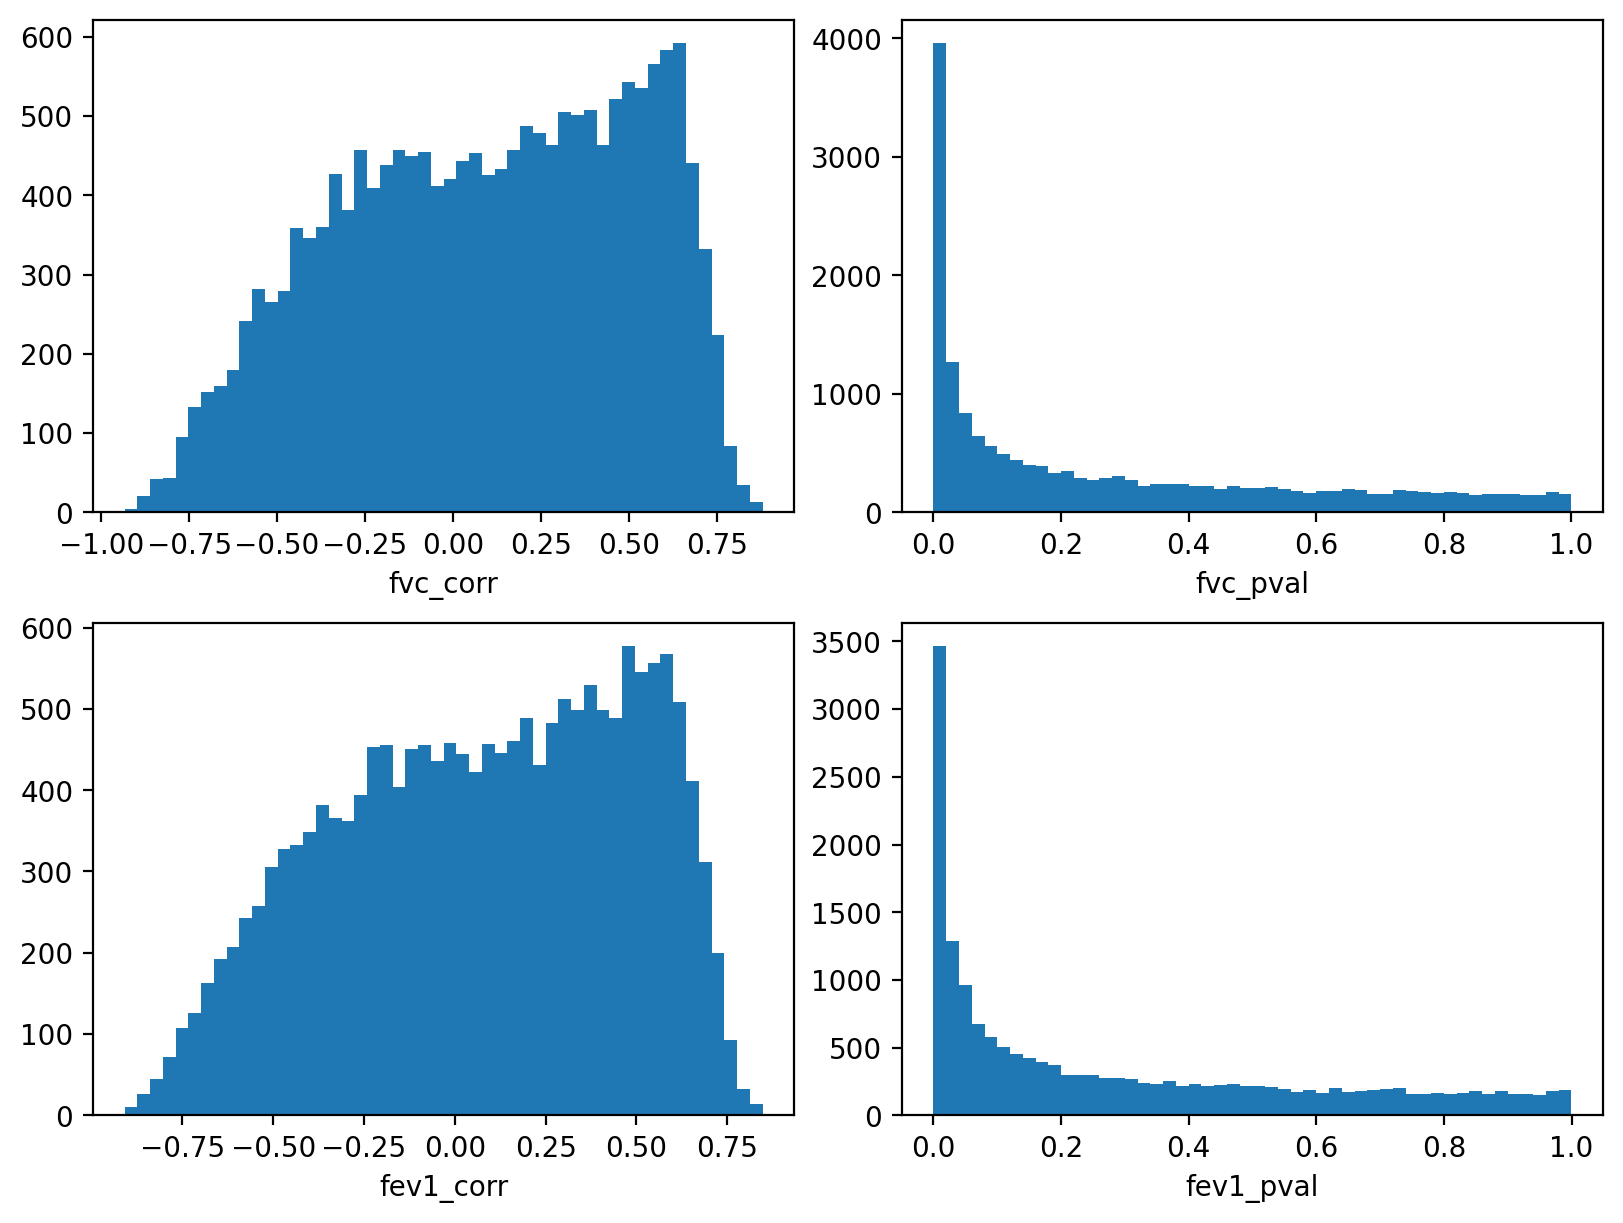

In [46]:
fig, axes = plt.subplots(figsize=(8, 6), ncols=2, nrows=2, constrained_layout=True)
for i, col in enumerate(
    ('fvc_corr', 'fvc_pval', 'fev1_corr', 'fev1_pval')
):
    ax = axes[i // 2, i % 2]
    ax.hist(result[col], bins=50)
    ax.set_xlabel(col)

In [47]:
result['fvc_padj'] = statsmodels.stats.multitest.fdrcorrection(result.fvc_pval)[1]
result['fev1_padj'] = statsmodels.stats.multitest.fdrcorrection(result.fev1_pval)[1]

In [48]:
result.sort_values('fvc_padj').head(20)

,gene,fvc_corr,fvc_pval,fev1_corr,fev1_pval,fvc_padj,fev1_padj
8265,FAM27C,-0.933343,4.560865e-08,-0.884003,2.510581e-06,0.000792,0.007092
12431,CCNB2,-0.895650,1.175696e-06,-0.861848,8.709857e-06,0.002725,0.007719
8358,CKS2,-0.900723,8.213806e-07,-0.878053,3.588428e-06,0.002725,0.007092
5713,DNPH1,-0.902611,7.152373e-07,-0.909019,4.375728e-07,0.002725,0.007092
7738,GGH,-0.894485,1.273307e-06,-0.859956,9.590141e-06,0.002725,0.007719
10429,CDCA3,-0.893198,1.389206e-06,-0.867121,6.609834e-06,0.002725,0.007575
6615,GAL3ST4,-0.908272,4.642228e-07,-0.890287,1.684859e-06,0.002725,0.007092
4328,MAD2L1,-0.893399,1.370540e-06,-0.847502,1.749201e-05,0.002725,0.010650
13069,PLK1,-0.892945,1.412953e-06,-0.866090,6.982538e-06,0.002725,0.007575
3292,NT5DC2,-0.887215,2.053472e-06,-0.882670,2.724249e-06,0.003084,0.007092


Text(0, 0.5, 'z-score$(FAM27C)$')

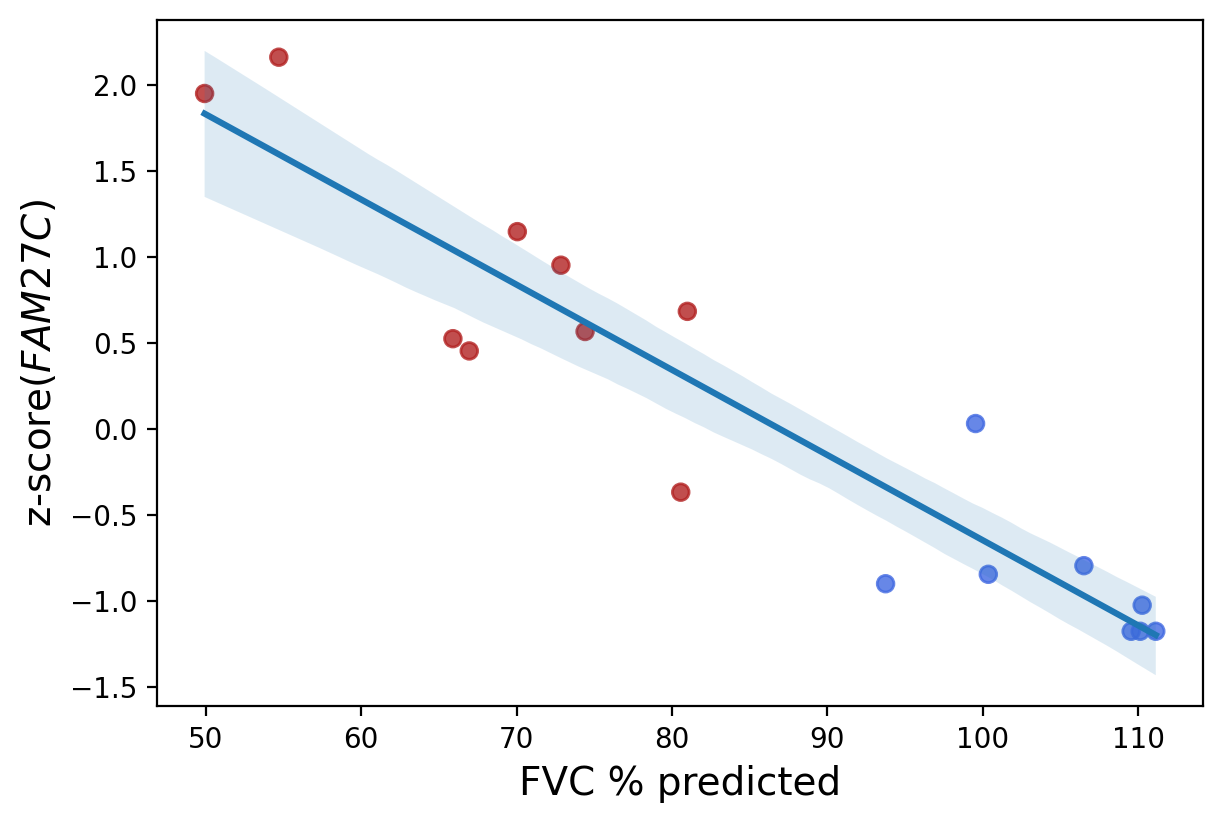

In [49]:
GENE = 'FAM27C'
idx = metadata_df.fvc_pred.notna()
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
sns.regplot(
    x=metadata_df.fvc_pred[idx],
    y=pseudobulk[GENE][idx],
    scatter_kws=dict(
        color=get_color_annotations(
            metadata_df[idx],
            {'Status': ['firebrick', 'royalblue']}
        ).Status.tolist()
    )
)
ax.set_xlabel('FVC % predicted', size=14)
ax.set_ylabel(f'z-score$({GENE})$', size=14)

In [50]:
result.sort_values('fvc_padj').to_csv('12b_genes_tram_corr.csv')

# 3. Linear models on genes, pseudobulk on the whole sample

In [15]:
metadata_df = ds_processed.obs[
    ['External Sample ID', 'Status']
].drop_duplicates(subset=['External Sample ID'])

In [16]:
pseudobulk = np.zeros((metadata_df.shape[0], ds_processed.raw.var_names.size))
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        ds_processed.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = ds_processed.raw.X[metadata_idx].mean(axis=0)

In [17]:
pseudobulk.shape

(23, 25538)

In [18]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=ds_processed.raw.var_names)

Take genes that are detected in 80% of pseudobulks in SSc

In [19]:
sample_idx = metadata_df.Status.eq('SSc')

In [20]:
gene_idx = (pseudobulk.loc[sample_idx, :].gt(0).sum(axis=0) / sample_idx.sum()).ge(0.8)

In [21]:
pseudobulk = pseudobulk.loc[:, gene_idx].copy()

In [22]:
gene_idx.sum()

19191

Remove non-protein coding genes, ribosomal, and funky transcripts. Porting from `11b` notebook

In [23]:
REF_GENOME_GTF = '/projects/b1038/tools/refdata-cellranger-GRCh38-1.2.0/genes/genes.gtf'

In [24]:
ref_genome = open(REF_GENOME_GTF).read().split('\n')

In [25]:
gene_info = []
for line in ref_genome:
    if not line or line[0] == '#':
        continue
    info = line.split('\t')
    line_type = info[2]
    if line_type != 'gene':
        continue
    data = {
        pair.strip().split()[0]: pair.strip().split()[1].strip('"')
        for pair in info[8].split(';')
        if pair.strip()
    }
    gene_info.append(data)
gene_info = pd.DataFrame(gene_info)

There are few duplicate gene names with conflicting biotypes, but we don't care about this: let's just take all gene names that have `protein_coding` biotype.

In [26]:
protein_coding_genes = gene_info.gene_name[gene_info.gene_biotype.eq('protein_coding')].unique()

In [27]:
# Either starts with all this, or ends with -AS1
FUNKY_TRANSCRIPTS = (
    '(^(RP\d{1,2}-|LINC|CT[ABCD]-|AC\d{6}|AL\d{6}'
    '|AP\d{6}|AF\d{6}|XXba|XXya|FO\d{6}|FP\d{6}).+|.+(-AS1)$)'
)

In [28]:
# additionally remove ribosomal genes and mito
REMOVE_GENES_BY_NAME = '^(RPL|RPS|MT-).+'
PROTEIN_CODING = protein_coding_genes

In [29]:
to_remove = (
    pseudobulk.columns.str.match(REMOVE_GENES_BY_NAME)
    | pseudobulk.columns.str.match(FUNKY_TRANSCRIPTS)
)

In [30]:
pseudobulk = pseudobulk.loc[:, ~to_remove]
pseudobulk.shape

(23, 15176)

In [31]:
pseudobulk = pseudobulk.loc[:, pseudobulk.columns.isin(PROTEIN_CODING)]
pseudobulk.shape

(23, 14783)

Remove genes by expression

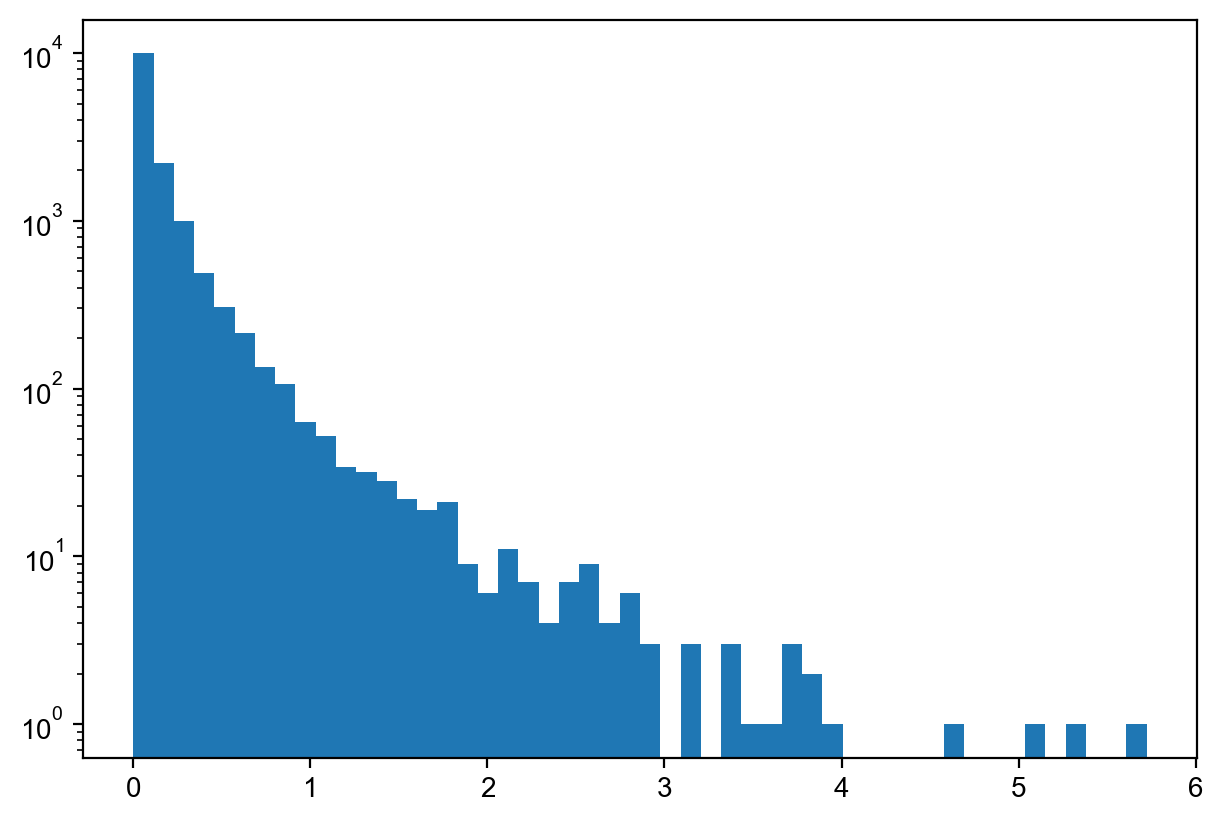

In [32]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.hist(pseudobulk.mean(axis=0), bins=50, log=True);

`0.1` = arbitrarily chosen threshold

In [33]:
pseudobulk = pseudobulk.loc[:, pseudobulk.mean(axis=0).gt(0.1)]
pseudobulk.shape

(23, 5294)

In [34]:
pseudobulk_zscore = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [42]:
idx = metadata_df['External Sample ID'].isin(sample_to_fvc.index)
metadata_df.loc[idx, 'fvc_pred'] = sample_to_fvc[metadata_df['External Sample ID'][idx]].values
metadata_df.loc[idx, 'fev1_pred'] = sample_to_fev1[metadata_df['External Sample ID'][idx]].values

In [43]:
result = []
for gene in pseudobulk_zscore.columns:
    idx = metadata_df.fvc_pred.notna()
    y = pseudobulk_zscore[gene][idx]
    x = metadata_df.fvc_pred[idx]
    fvc_fit = scipy.stats.pearsonr(x, y)
    x = metadata_df.fev1_pred[idx]
    fev1_fit = scipy.stats.pearsonr(x, y)
    result.append((
        gene,
        fvc_fit.statistic,
        fvc_fit.pvalue,
        fev1_fit.statistic,
        fev1_fit.pvalue,
    ))
result = pd.DataFrame(
    result,
    columns=['gene', 'fvc_corr', 'fvc_pval', 'fev1_corr', 'fev1_pval']
)

In [44]:
result['fvc_padj'] = statsmodels.stats.multitest.fdrcorrection(result.fvc_pval, alpha=0.05)[1]
result['fev1_padj'] = statsmodels.stats.multitest.fdrcorrection(result.fev1_pval, alpha=0.05)[1]

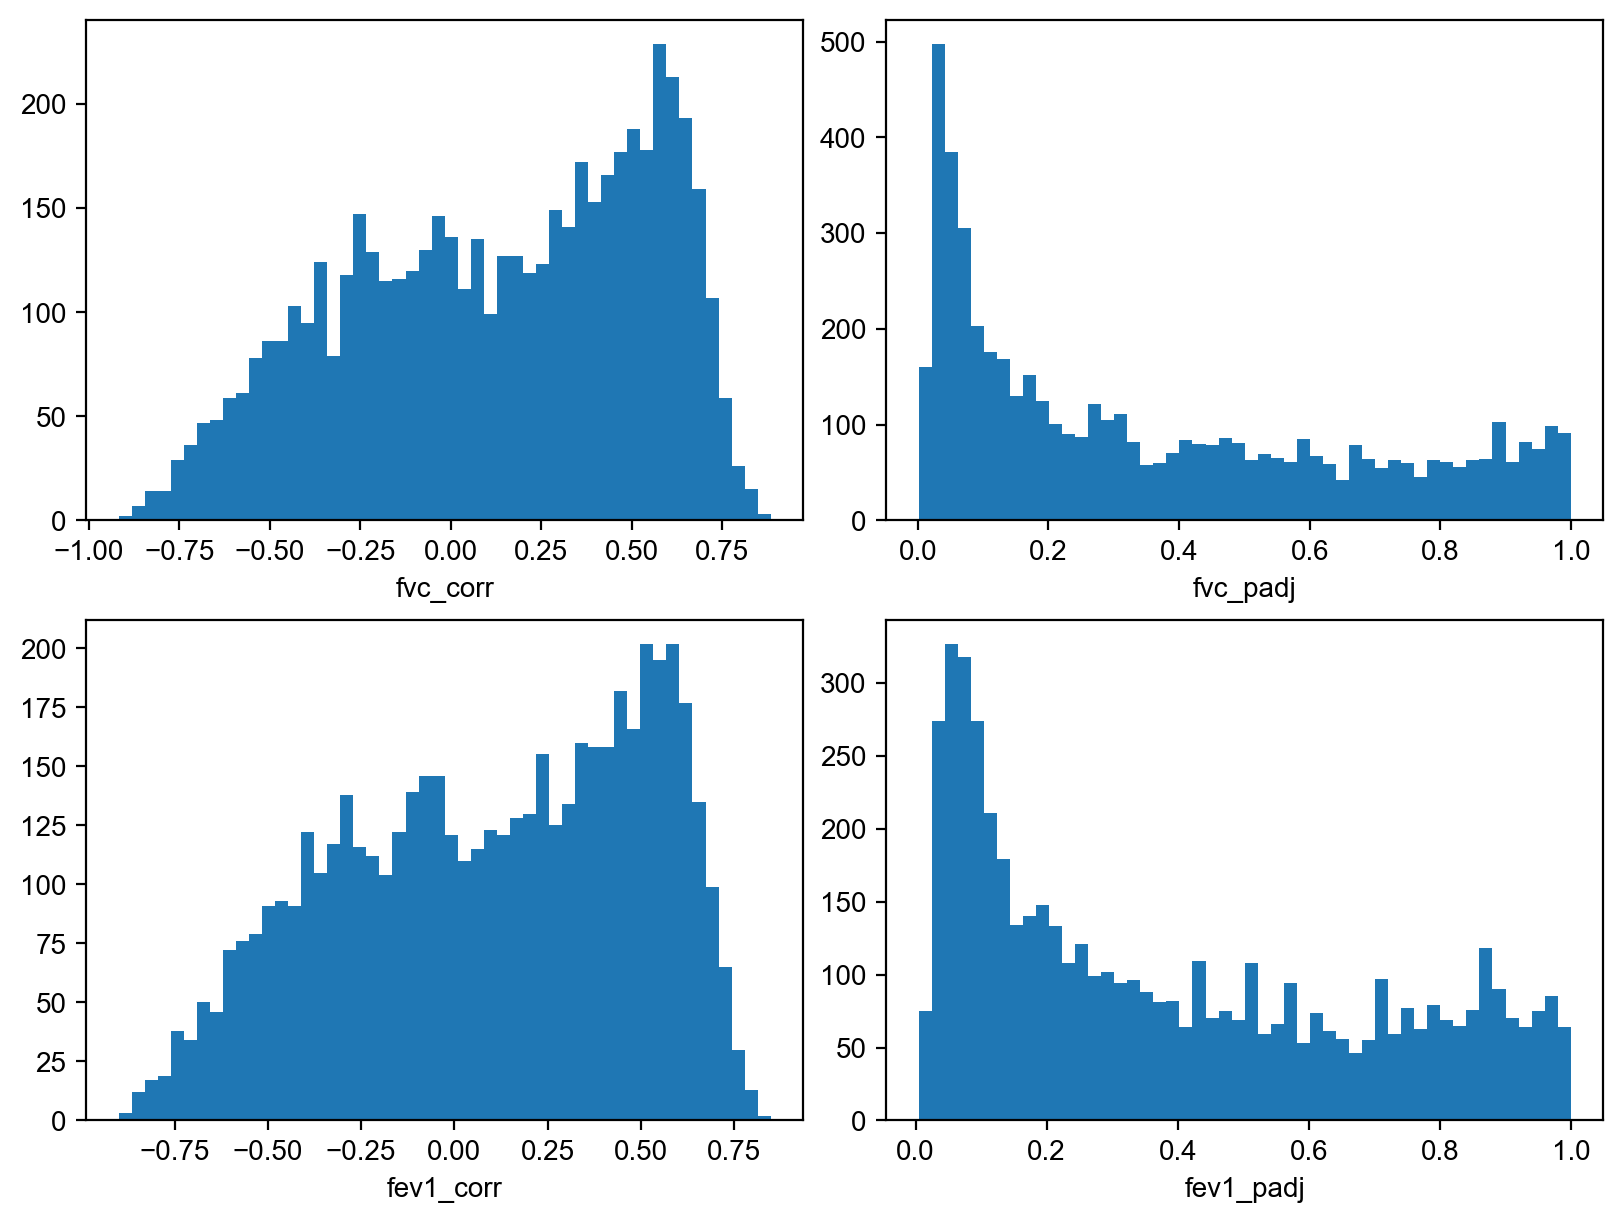

In [45]:
fig, axes = plt.subplots(figsize=(8, 6), ncols=2, nrows=2, constrained_layout=True)
for i, col in enumerate(
    ('fvc_corr', 'fvc_padj', 'fev1_corr', 'fev1_padj')
):
    ax = axes[i // 2, i % 2]
    ax.hist(result[col], bins=50)
    ax.set_xlabel(col)

Use strict cutoff of _q_-value < `0.01` for emphasis and to narrow down the results

In [46]:
result.fvc_padj.lt(0.01).sum()

42

In [47]:
result.fev1_padj.lt(0.01).sum()

2

In [48]:
result['avg_expr'] = pseudobulk.mean(axis=0).values

In [49]:
result['control_std'] = pseudobulk.loc[metadata_df.Status.eq('control')].std(ddof=1).values
result['ssc_std'] = pseudobulk.loc[metadata_df.Status.eq('SSc')].std(ddof=1).values

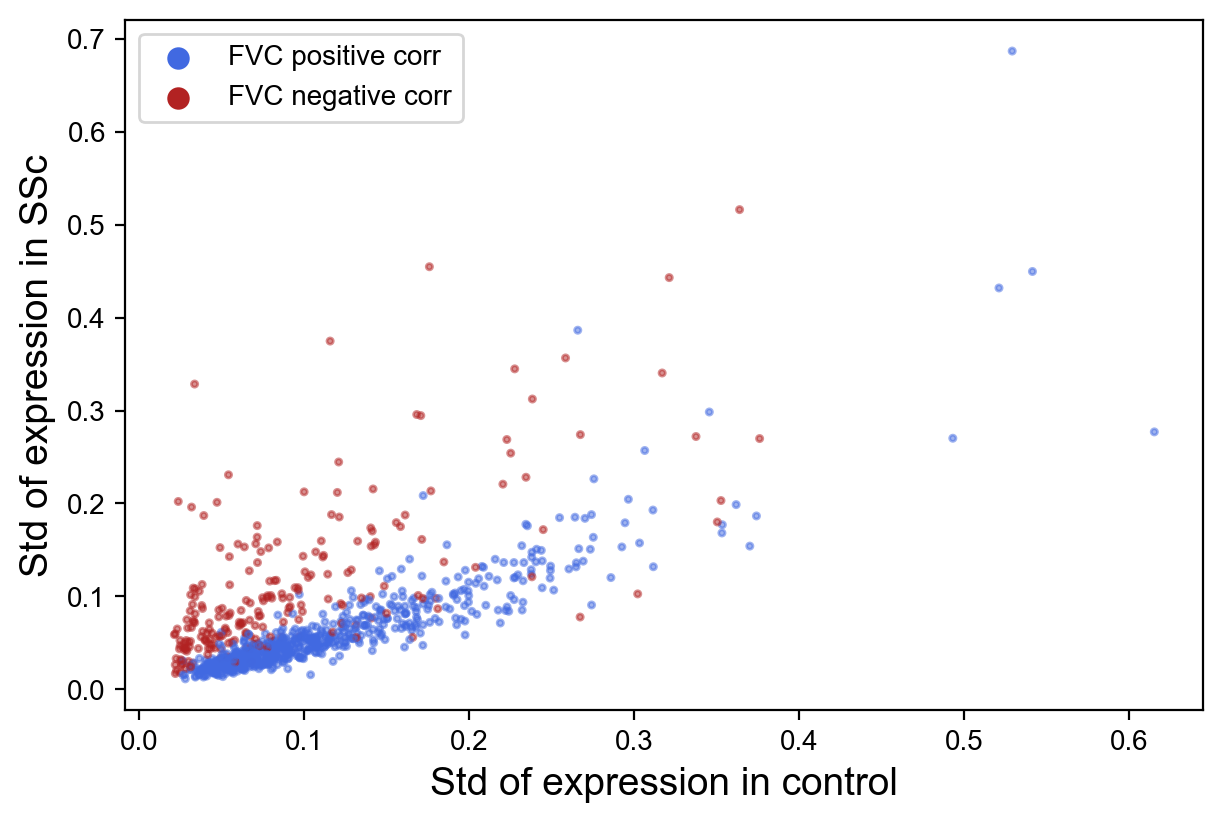

In [50]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
idx = result.fvc_padj.lt(0.05)
ax.scatter(
    result.control_std[idx],
    result.ssc_std[idx],
    c=result.fvc_corr[idx].gt(0).replace({True: 'royalblue', False: 'firebrick'}),
    s=5,
    alpha=0.5
)
ax.set_xlabel('Std of expression in control', size=14)
ax.set_ylabel('Std of expression in SSc', size=14)
ax.legend(
    handles=[
        plt.scatter([], [], c='royalblue', s=50, label='FVC positive corr'),
        plt.scatter([], [], c='firebrick', s=50, label='FVC negative corr')
    ],
    loc='upper left'
)

Text(0, 0.5, 'Count')

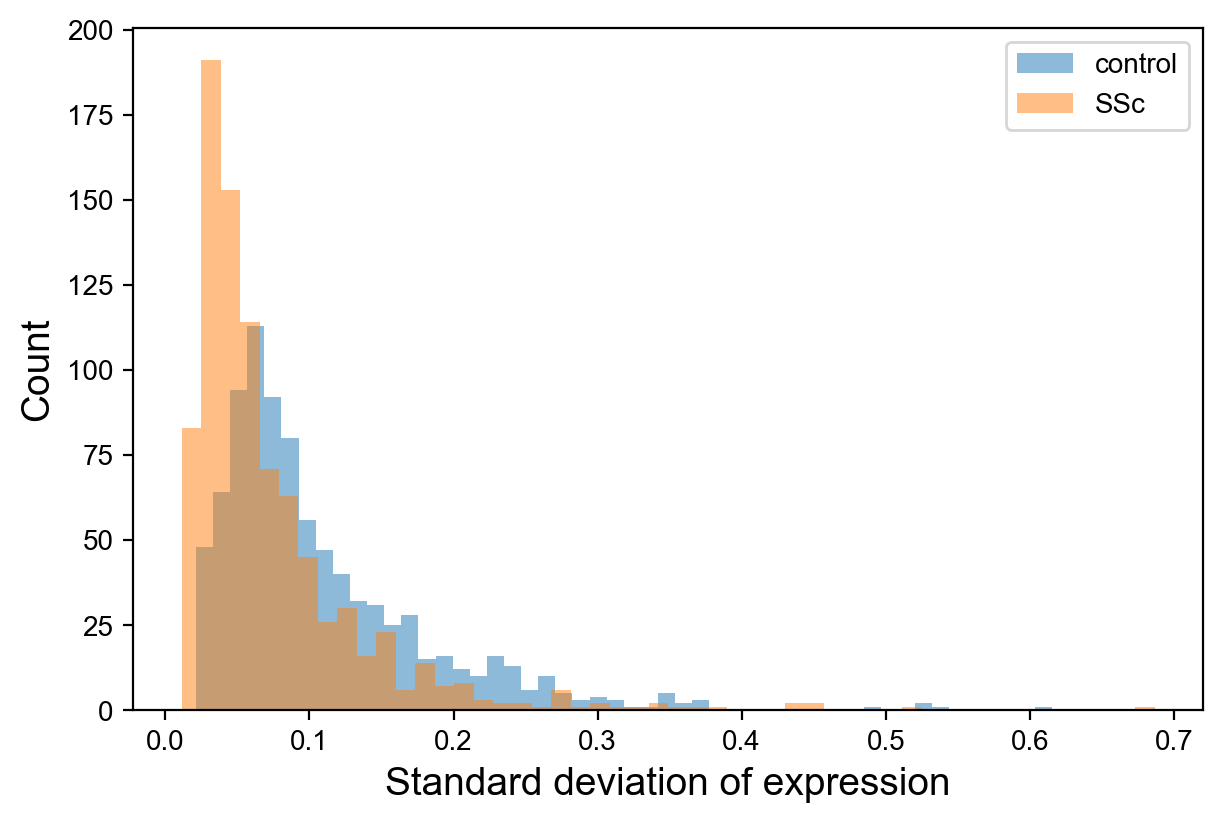

In [51]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.hist(result.control_std[idx], bins=50, label='control', alpha=0.5)
ax.hist(result.ssc_std[idx], bins=50, label='SSc', alpha=0.5)
ax.legend()
ax.set_xlabel('Standard deviation of expression', size=14)
ax.set_ylabel('Count', size=14)

In [52]:
result.loc[result.fvc_padj.lt(0.01)].sort_values('fvc_corr')

,gene,fvc_corr,fvc_pval,fev1_corr,fev1_pval,fvc_padj,fev1_padj,avg_expr,control_std,ssc_std
1898,MARCKS,-0.917788,2.100261e-07,-0.887291,2.043651e-06,0.001112,0.005410,0.174374,0.036263,0.105622
1836,DNPH1,-0.905653,5.689128e-07,-0.900393,8.412789e-07,0.001506,0.004454,0.174947,0.037770,0.090274
3847,LGMN,-0.878053,3.588545e-06,-0.849304,1.608821e-05,0.004749,0.010148,0.240082,0.054543,0.142792
3130,CREM,-0.864767,7.486927e-06,-0.859414,9.855459e-06,0.006688,0.010148,0.136950,0.026534,0.045625
3700,RNASE6,-0.864531,7.580106e-06,-0.836308,2.875204e-05,0.006688,0.010148,0.238255,0.063613,0.153244
4990,TMEM147,-0.854160,1.277186e-05,-0.858545,1.029455e-05,0.007348,0.010148,0.527124,0.098779,0.083768
5051,CALM3,-0.853776,1.301074e-05,-0.821646,5.229555e-05,0.007348,0.012039,0.579699,0.091415,0.089311
5089,FPR3,-0.852128,1.408108e-05,-0.844325,2.021961e-05,0.007348,0.010148,0.276457,0.059714,0.156371
3083,KLF6,-0.850032,1.554858e-05,-0.805950,9.377263e-05,0.007348,0.015139,0.901614,0.237934,0.121123
2241,AP1S2,-0.844628,1.994465e-05,-0.865691,7.131391e-06,0.007348,0.010148,0.413885,0.078352,0.152229


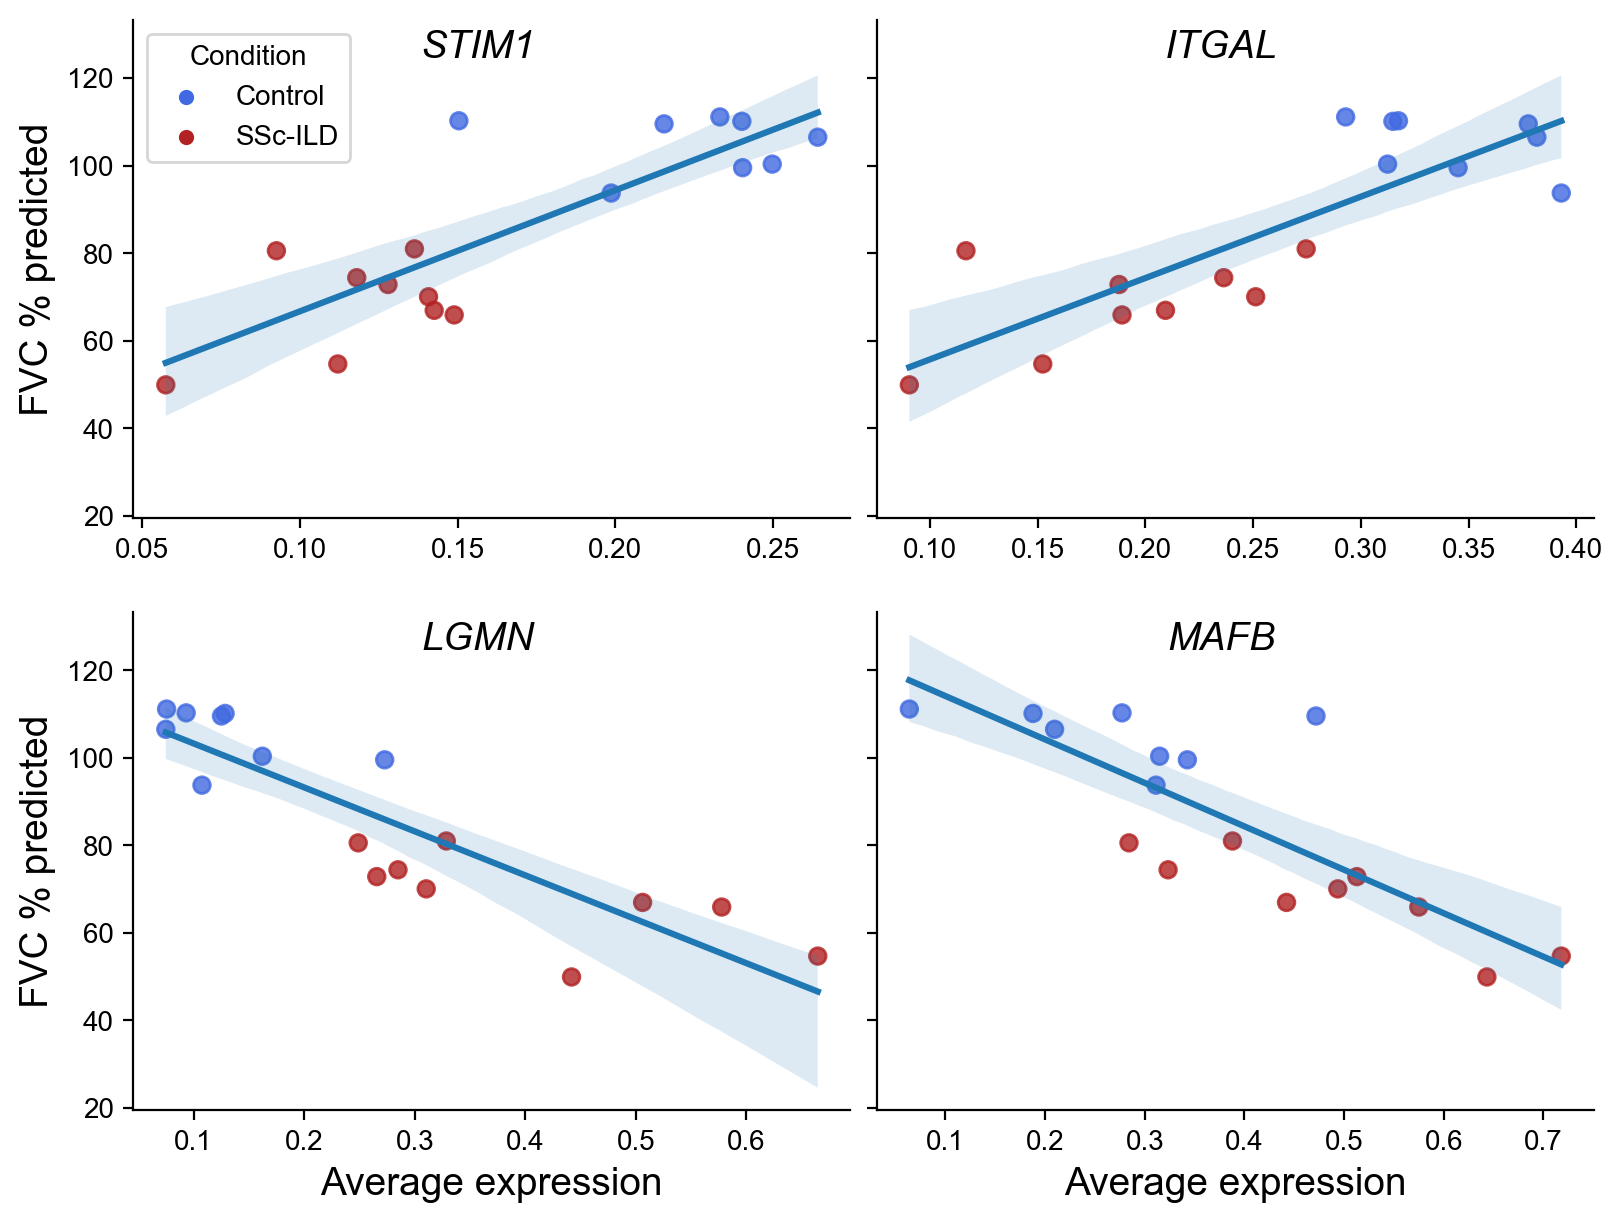

In [ ]:
GENES = ['STIM1', 'ITGAL', 'LGMN', 'MAFB']
idx = metadata_df.fvc_pred.notna()
fig, axes = plt.subplots(
    figsize=(8, 6), ncols=2, nrows=2,
    constrained_layout=True, sharex=False, sharey=True,
    gridspec_kw=dict(hspace=0.08)
)
for i, GENE in enumerate(GENES):
    ax = axes[i // 2, i % 2]
    sns.regplot(
        y=metadata_df.fvc_pred[idx],
        x=pseudobulk[GENE][idx],
        scatter_kws=dict(
            color=get_color_annotations(
                metadata_df[idx],
                {'Status': ['firebrick', 'royalblue']}
            ).Status.tolist()
        ),
        ax=ax
    )
    if i % 2 == 0:
        ax.set_ylabel('FVC % predicted', size=14)
    else:
        ax.set_ylabel('')
    if i >= 2:
        ax.set_xlabel(f'Average expression', size=14)
    else:
        ax.set_xlabel('')
    ax.spines[['top', 'right']].set_visible(False)
    xlim = ax.get_xlim()
    ax.text(
        xlim[0] + (xlim[1] - xlim[0]) * 0.48,
        0.98,
        f'{GENE}',
        size=14,
        fontdict={'style': 'italic'},
        # pad=0,
        transform=ax.get_xaxis_transform(),
        ha='center',
        va='top',
    )
    if i == 0:
        ax.legend(
            handles=[
                plt.scatter([], [], c='royalblue', s=20, label='Control'),
                plt.scatter([], [], c='firebrick', s=20, label='SSc-ILD'),
            ],
            loc='upper left',
            title='Condition',
        )
fig.savefig('00_figures/Figure_S2E_fvc_corr_biomarkers.pdf')

In [94]:
result.sort_values('fvc_corr').to_csv('12c_genes_all_cells_corr.csv')

In [98]:
result.sort_values('fvc_corr').to_csv('00_figures/Table_S6_fvc_corr_biomarkers.csv', index=False)